<a href="https://colab.research.google.com/github/BuczynskiRafal/pipe_calculations/blob/main/OOP_Catchments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install extensions

In [1]:
!pip install pyswmm
!pip install swmmio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 3.7 MB/s 
     |████████████████████████████████| 131 kB 44.6 MB/s 
     |████████████████████████████████| 458 kB 28.2 MB/s 
  Created wheel for julian: filename=julian-0.14-py3-none-any.whl size=2633 sha256=3c0a3ea27e0b4f861b9172c37291b037563e89fa6991dac1233c145ace6a2e62
  Stored in directory: /root/.cache/pip/wheels/bb/58/2a/4109ff5870c163b26a499fb8b828ede50e96264571a4f082d3
Successfully built julian
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 9.2 MB/s 
     |████████████████████████████████| 215 kB 54.5 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-py3-none-any.whl size=32667 sha256=15694c9d7fb718f61648a0a752e77f8e05b58de875ad4907ef7a3a4868b4fe10
  Stored in directory: /root/.cache/pip/wheels/a0/c5/f3/548a073ac6a83d5b23d9b39cdd243

# Import extensions

In [2]:
import swmmio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyswmm import Simulation, Nodes, Links, Subcatchments, Output

# Explore model data

In [3]:
model = swmmio.Model('example.inp')
df_links = model.links.dataframe
df_subcatchments = model.subcatchments.dataframe

In [ ]:
df_links[:2]

,InletNode,OutletNode,...,Barrels,coords
Name,,,,,
C3,J1,J3,...,1,"[(777189.014, 592583.674), (777197.821, 592564.501)]"
C4,J3,O4,...,1,"[(777197.821, 592564.501), (777203.103, 592557.13)]"


In [ ]:
df_subcatchments[:2]

,Raingage,Outlet,...,RouteTo,coords
Name,,,,,
S1,1,J1,...,OUTLET,"[(777175.934, 592588.598), (777185.333, 592588.986), (777185.453, 592579.676), (777176.173, 592579.527), (777175.934, 592588.717), (777175.934, 592588.598)]"


# Prepare methoed for sumulation

In [48]:
class PipeData:
    def __init__(self):
        self.flow_turn_sign = []
        self.flow_turns = []
        self.peak_depth = []        # maksymalna wysokość napełnienia kanału [m]
        self.peak_flow = []         # maksymaly przepływ [m3/s]
        self.peak_flow_date = []
        self.peak_velocity = []     # maksymalna prędkość przepływu [m/s]
        self.time_capacity_limited = []
        self.time_courant_crit = []
        self.time_full_downstream = []
        self.time_full_flow = []
        self.time_full_upstream = []
        self.time_normal_flow = []

class CatchmentData:
    def __init__(self):
        self.runoff = []
        self.peak_runoff_rate = []
        self.infiltration = []
        self.evaporation = []
        self.slope = []
        # self.percent_impervious = []
        # self.area = []


class Analyse:
    def __init__(self, file_path='example.inp'):
        self.pipe_data = PipeData()
        self.catchment_data = CatchmentData()
        self._file_path = file_path

    def show_subcatchment(self):
        with Simulation(self._file_path) as sim:
            return [subcatchment.subcatchmentid for subcatchment in Subcatchments(sim)]

    def show_conduits(self):
        with Simulation(self._file_path) as sim:
            return [conduit.linkid for conduit in Links(sim)]

    def save_model(self):
        # pyswmm not allow to manage diameter of pipe 
        # this is why it is nessesary to use swmmio 
        # to overide model data (max. depth - pipe diameter)
        pass

    def overide_diameter(self):
        pass
    
    def analyse(self, conduit_id=None, subcatchment_id=None, min_slope=0.1, max_slope=100, step=0.1):
        iterator = []
        counter = min_slope
        while counter < max_slope:
            counter += step
            iterator.append(counter)
        for area in range(1, 11, 1):
            for slope in iterator:
                for imprevious in iterator:
                    with Simulation(self._file_path) as sim:
                        catchment = Subcatchments(sim)[subcatchment_id]
                        conduit = Links(sim)[conduit_id]
                        catchment.slope = slope
                        catchment.percent_impervious = imprevious
                        catchment.area = area
                        self.catchment_data.slope.append(slope)
                        self.catchment_data.percent_impervious.append(imprevious) 
                        self.catchment_data.area.append(area)
                        for _ in sim:
                            pass
                        catchment_stats = catchment.statistics
                        conduit_stats = conduit.conduit_statistics
                        try:
                            for key in vars(self.catchment_data):
                                getattr(self.catchment_data, key).append(catchment_stats[key])
                        except KeyError:
                            pass
                        try:
                            for key in vars(self.pipe_data):
                                getattr(self.pipe_data, key).append(conduit_stats[key])
                        except KeyError:
                            pass
            print(f"loop: {area}")
        return None

    def slope_simulation(self, conduit_id=None, subcatchment_id=None, min_slope=1, max_slope=101, step=1):
        min_slope, max_slope, step = min_slope / 100, max_slope / 100, step / 100
        counter = min_slope
        while counter < max_slope:
            with Simulation(self._file_path) as sim:
                conduit = Links(sim)[conduit_id]
                catchment = Subcatchments(sim)[subcatchment_id]
                catchment.slope = counter
                for _ in sim:
                    pass
                conduit_stats = conduit.conduit_statistics
                catchment_stats = catchment.statistics
                try:
                    for key in vars(self.catchment_data):
                        getattr(self.catchment_data, key).append(catchment_stats[key])
                except KeyError:
                    pass
                try:
                    for key in vars(self.pipe_data):
                        getattr(self.pipe_data, key).append(conduit_stats[key])
                except KeyError:
                    pass
                self.catchment_data.slope.append(counter * 100)
                counter += step
        return None

# Do simulation

In [49]:
slope_analyse = Analyse()
slope_analyse.slope_simulation("C3", "S1")

In [50]:
for key, value in vars(slope_analyse.catchment_data).items():
    print(f"key: {key}, vals: {len(value)}")

key: runoff, vals: 100
key: peak_runoff_rate, vals: 100
key: infiltration, vals: 100
key: evaporation, vals: 100
key: slope, vals: 100


# Prepare dataframe



In [51]:
data = {**vars(slope_analyse.pipe_data), **vars(slope_analyse.catchment_data)}
df_raw = pd.DataFrame(data=data)

# Data for work

In [52]:
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   flow_turn_sign         100 non-null    int64  
 1   flow_turns             100 non-null    int64  
 2   peak_depth             100 non-null    float64
 3   peak_flow              100 non-null    float64
 4   peak_flow_date         100 non-null    float64
 5   peak_velocity          100 non-null    float64
 6   time_capacity_limited  100 non-null    float64
 7   time_courant_crit      100 non-null    float64
 8   time_full_downstream   100 non-null    float64
 9   time_full_flow         100 non-null    float64
 10  time_full_upstream     100 non-null    float64
 11  time_normal_flow       100 non-null    float64
 12  runoff                 100 non-null    float64
 13  peak_runoff_rate       100 non-null    float64
 14  infiltration           100 non-null    float64
 15  evapora

In [53]:
df.head()

,flow_turn_sign,flow_turns,...,evaporation,slope
0,-1,333,...,0.0,1.0
1,-1,303,...,0.0,2.0
2,1,287,...,0.0,3.0
3,1,279,...,0.0,4.0
4,1,239,...,0.0,5.0


In [54]:
df.shape

(100, 17)

In [55]:
df.describe().T

,count,mean,...,75%,max
flow_turn_sign,100.0,0.620000,...,1.000000,1.000000
flow_turns,100.0,205.840000,...,205.000000,333.000000
peak_depth,100.0,0.622650,...,0.623468,0.623473
peak_flow,100.0,1.538946,...,1.542300,1.542330
peak_flow_date,100.0,44729.041645,...,44729.041707,44729.041854
peak_velocity,100.0,3.045202,...,3.048559,3.049826
time_capacity_limited,100.0,0.000000,...,0.000000,0.000000
time_courant_crit,100.0,0.034258,...,0.037778,0.038056
time_full_downstream,100.0,0.000000,...,0.000000,0.000000
time_full_flow,100.0,0.225488,...,0.246109,0.254155


# Remove unused columns

In [56]:
df.drop(columns=['flow_turn_sign', 'flow_turns', 'time_capacity_limited', 'time_courant_crit', 'time_full_downstream', 'time_full_upstream'], axis=1, inplace=True)
df.head()

,peak_depth,peak_flow,...,evaporation,slope
0,0.594745,1.426818,...,0.0,1.0
1,0.609481,1.485377,...,0.0,2.0
2,0.615045,1.509378,...,0.0,3.0
3,0.618000,1.518762,...,0.0,4.0
4,0.619274,1.526106,...,0.0,5.0


In [57]:
df.columns

Index(['peak_depth', 'peak_flow', 'peak_flow_date', 'peak_velocity',
       'time_full_flow', 'time_normal_flow', 'runoff', 'peak_runoff_rate',
       'infiltration', 'evaporation', 'slope'],
      dtype='object')

# Subcatchments data output

## Dependence of runoff on subcatchment slope.

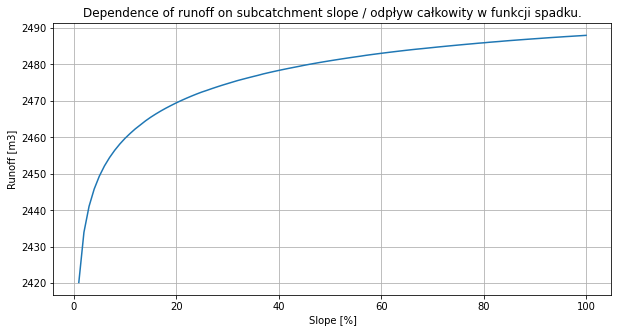

In [58]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['runoff'])
plt.title('Dependence of runoff on subcatchment slope / odpływ całkowity w funkcji spadku.')
plt.xlabel('Slope [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

## Dependence of peak runoff rate on subcatchment slope

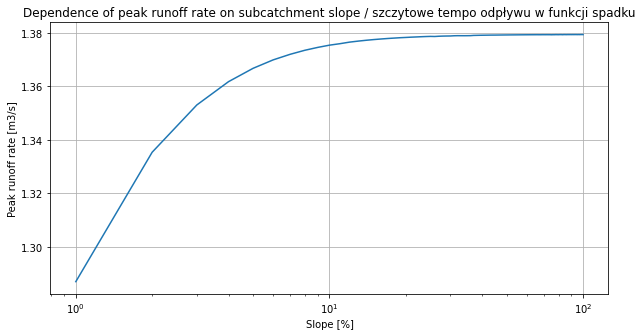

In [59]:
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment slope / szczytowe tempo odpływu w funkcji spadku')
plt.xlabel('Slope [%]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

## Dependence of infiltration on subcatchment slope

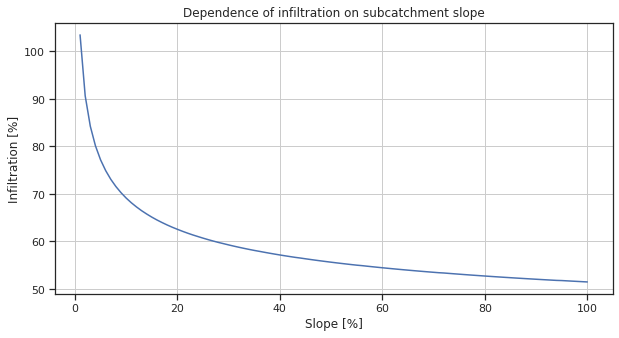

In [68]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['infiltration'])
plt.title('Dependence of infiltration on subcatchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Infiltration [%]')
plt.grid(True)
plt.show()

# Pipes data output

## Dependence of maximal flow on subcatchment slope.

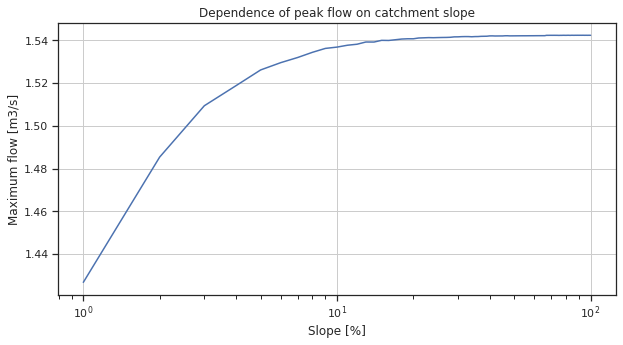

In [70]:
# maksymaly przepływ [m3/s] w funkcji spadku terenu zlewni.
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_flow'])
plt.title('Dependence of peak flow on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum flow [m3/s]')
plt.grid(True)
plt.show()

## Dependence of maximal velocity on subcatchment slope

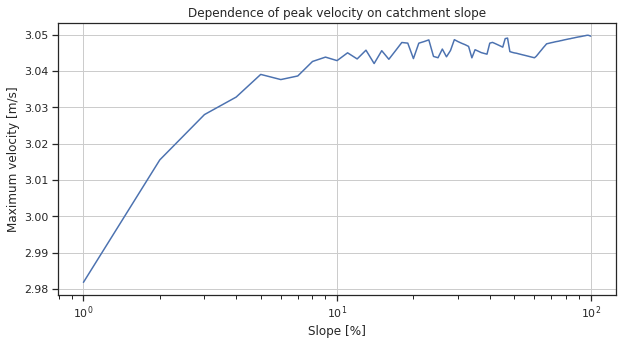

In [71]:
# peak_velocity - maksymalna prędkość przepływu [m/s]
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_velocity'])
plt.title('Dependence of peak velocity on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum velocity [m/s]')
plt.grid(True)
plt.show()

## Dependence of maximal pipe filling on subcatchment slope.

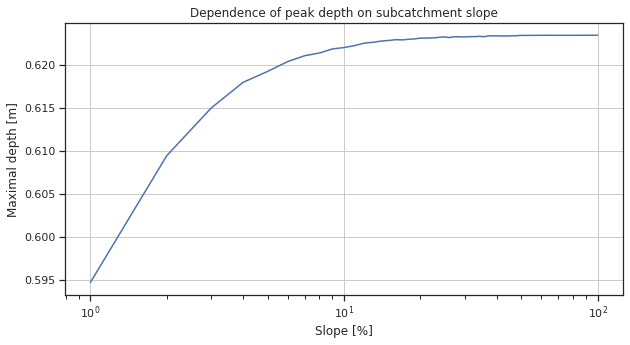

In [67]:
# maksymalna wysokość napełnienia kanału  w sunkcji spadku terenu zlewni [m]
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_depth'])
plt.title('Dependence of peak depth on subcatchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximal depth [m]')
plt.grid(True)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


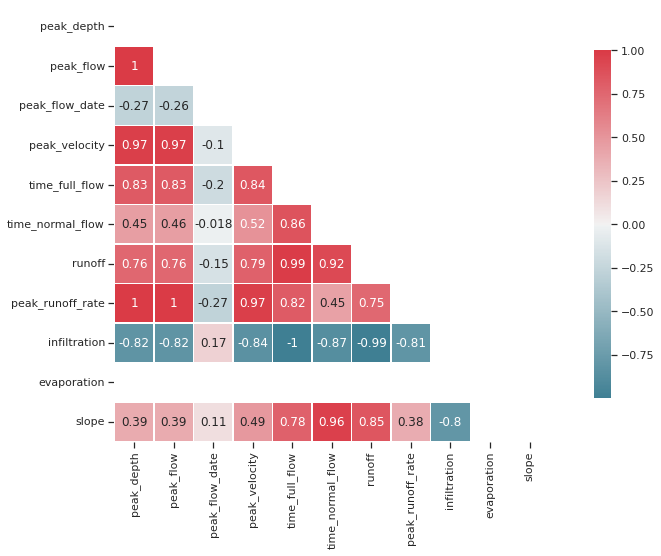

In [64]:
df_slope_corr = df.copy()
corr = df_slope_corr.corr()

sns.set(style="ticks")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(16, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8})